In [1]:
# We need to install the HuggingFace dataset library to import the FairFace data below
%%capture
pip install datasets

In [2]:
import random
import numpy as np
import requests
import cv2
from collections import defaultdict

import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.patches as patches

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

from datasets import load_dataset

from scipy.ndimage import generic_filter
from skimage import io, color, img_as_ubyte
from skimage.transform import integral_image
from skimage.feature import haar_like_feature, haar_like_feature_coord, draw_haar_like_feature

In [3]:
# Load images of handwritten digits
from tensorflow.keras.datasets import mnist # We only use tensorflow to load the data
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


In [4]:
# Inspect the datatype
print(type(train_images))
print(train_images.shape)

<class 'numpy.ndarray'>
(60000, 28, 28)


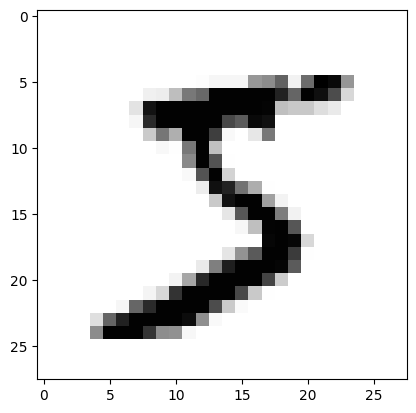

In [5]:
# Display one of the images
plt.figure()
plt.imshow(train_images[0], cmap='Greys')
plt.show()

In [6]:
# Look at the values in the array
# print(train_images[0])

In [7]:
# Let's normalize and flatten the values
train_images = train_images.reshape(train_images.shape[0], -1) / 255.0
test_images = test_images.reshape(test_images.shape[0], -1) / 255.0

In [8]:
# Inspect again
# print(train_images[0])
print(type(train_images))
print(train_images.shape)

# Why did we flatten the images?

<class 'numpy.ndarray'>
(60000, 784)


Can we use the arrays directly as input features or do we have to extract features first?

Hint: here, we can perform direct pixel-based analysis. But why?

In [9]:
# We could use various machine learning algorithms...
# Let's start with a support vector machine
model = SVC(kernel='rbf')
model.fit(train_images, train_labels)

SVC()

In [10]:
# Make the predictions and calculate the accuracy
test_labels_predicted = model.predict(test_images)

accuracy = accuracy_score(test_labels, test_labels_predicted)
print(round(accuracy,2))

0.98


Do you think the above performance is good?

In [11]:
# We can also perform grid search to tune the hyperparameters
# The code is uncommented for now since it takes too much time to be run in the class

# Uncomment the next six lines if you want to do grid search
# param_grid = {'C': [0.1, 1], 'gamma': [1, 0.1]}
# grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=2)
# grid.fit(train_images, train_labels)

# test_labels_predicted_grid = grid.best_estimator_.predict(test_images)
# accuracy_grid = accuracy_score(test_labels, test_labels_predicted_grid)
# print(round(accuracy_grid,2))

# C is a regularization parameter: a low C makes the decision surface smooth, while a high C aims at classifying all training examples correctly
# To avoid overfitting in an SVM, we typically choose a lower C value
# gamma defins how far the influence of a single training example reaches in an RBF kernel SVM, affecting the smoothness of the model
# Accordingly, a low gamma value will create a more generalized model, while a high gamma value will create a more complex model

# Intuitively, C is about ``hardness'' or ``softness'' of the margin
# gamma is more about the shape and influence of the decision boundary, defining how it adapts and moves around data points.

Next, we are going to run a little auditing exercise for CV2's pre-trained Cascade (Viola-Jones) classifier for face detection. Specifically, we are asking whether it's accuracy to detect a face varies by the race of the person.

What do we need for this exercise?

- We need a dataset with faces from persons of different ethnicities (ideally in balanced numbers, such that we have similar observation numbers for all ethnicities). We will load a dataset from FairFace, which provides exactly that. To read more on the FairFace project, move here: https://github.com/joojs/fairface. We are importing the FairFace dataset via HuggingFace.
- We need ground truth on the ethnicity of the face/person. We are going to assume that FairFace's annotations are accurate enough to represent ground truth. Of course, it is very important here that the ground truth is equally accurate for all races (otherwise it would not be *ground truth*)!
- Disclaimer: since the FairFace data only contains face images (and no non-face images), we can only evaluate if the true positives versus the false negatives are balanced across races. That is, we do not evaluate if non-faces are more likely to be annotated as one race versus another.

In [12]:
# First, let us load the pre-trained Haar Cascade for face detection from OpenCV (Viola-Jones)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [13]:
# Now, load the FairFace dataset
dataset = load_dataset('HuggingFaceM4/FairFace')

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

In [14]:
# Let's inspect the train/validation split
# Some datasets on Hugging Face come with predefined splits (depends how the author organized them)
# However, commonly used splits include "train", "validation", and "test", but other splits may be available
print(dataset.num_rows)

{'train': 86744, 'validation': 10954}


In [15]:
# Since we are not training any model here, we do not really need the split
# For illustrative purposes, let's still split the dataset
train_dataset = dataset['train']
test_dataset = dataset['validation']

In [16]:
# What features do we have available?
# We will need the "image" (in this entry, the image is stored as a PIL object)...
# ... as well as the race (recall that the FairFace annotation will be our ground truth here)
print(train_dataset.features)

{'image': Image(decode=True, id=None), 'age': ClassLabel(names=['0-2', '3-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', 'more than 70'], id=None), 'gender': ClassLabel(names=['Male', 'Female'], id=None), 'race': ClassLabel(names=['East Asian', 'Indian', 'Black', 'White', 'Middle Eastern', 'Latino_Hispanic', 'Southeast Asian'], id=None), 'service_test': Value(dtype='bool', id=None)}


In [17]:
# How does this dataset object look like, what what is its type?
print(train_dataset)
print(type(train_dataset))

Dataset({
    features: ['image', 'age', 'gender', 'race', 'service_test'],
    num_rows: 86744
})
<class 'datasets.arrow_dataset.Dataset'>


In [18]:
# Randomly sample N examples from train_dataset (to keep our runtime reasonably short)
n_samples = 100
random_indices = random.sample(range(len(train_dataset)), n_samples)
sampled_data = [train_dataset[i] for i in random_indices]

In [19]:
# Now, let us set some lists for plotting later
# Set the race labels...
race_labels = train_dataset.features['race'].names
print(race_labels)
# ... and define some colors for these races
plotting_colors = ['#08306b', '#08519c', '#2171b5', '#4292c6', '#6baed6', '#9ecae1', '#c6dbef']

['East Asian', 'Indian', 'Black', 'White', 'Middle Eastern', 'Latino_Hispanic', 'Southeast Asian']


In [20]:
# We will now loop over all images and try to detect a face with the CV2 Cascade classifier
# We will count both the number of faces checked by race, as well as the number of actually detected faces
# We store these counts in dictionaires, we we initialize now
total_counts = defaultdict(int)
detected_counts = defaultdict(int)

# Next, we start looping over the images and see if at least one face is detected
# Of course, this is a bit of a simplification (we assume that the actual face on the image is detected, and not some peripheral artefact)
for example in sampled_data:
    pil_image = example['image']
    image = np.array(pil_image)
    race = example['race']

    total_counts[race] += 1
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    if len(faces) > 0:
        detected_counts[race] += 1

# Calculate the shares of detected faces over total faces (by race)
shares = {race: detected_counts[race] / total_counts[race] for race in total_counts.keys()}

# Updating the race keys from integers to string labels (for more interpretable plotting)
shares_with_labels = {race_labels[race]: share for race, share in shares.items()}

<ipython-input-21-29f5db845b0c>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(races, rotation=45, ha="right")


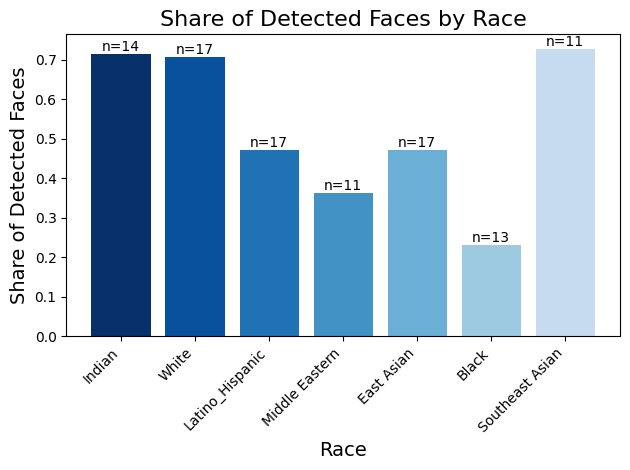

In [21]:
# Now, we are plotting the results in a bar plot
# The bar height shows the share of identified faces

fig, ax = plt.subplots()
races = list(shares_with_labels.keys())
values = list(shares_with_labels.values())

bars = ax.bar(races, values, color=plotting_colors)
ax.set_xlabel('Race', fontsize=14)
ax.set_ylabel('Share of Detected Faces', fontsize=14)
ax.set_title('Share of Detected Faces by Race', fontsize=16)
ax.set_xticklabels(races, rotation=45, ha="right")

# On top of each bar, let's add the total count of faces we checked
# Since FairFace promises a dataset that is equal representation of all races, the counts should be rather balanced
for bar, race in zip(bars, races):
    yval = bar.get_height()
    total = total_counts[race_labels.index(race)]  # get the total count for the race
    ax.text(bar.get_x() + bar.get_width()/2, yval, f'n={total}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [22]:
# Let's redo the plot with error bars
# We use the the formula for the standard error of a proportion
# (Derived from the principles of sampling distributions, Bernoulli is sending his warm greetings from your statistics class)

# As you increase the number of samples, you will see that the error bars get rather small

<ipython-input-23-c1d860255294>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(races, rotation=45, ha="right")


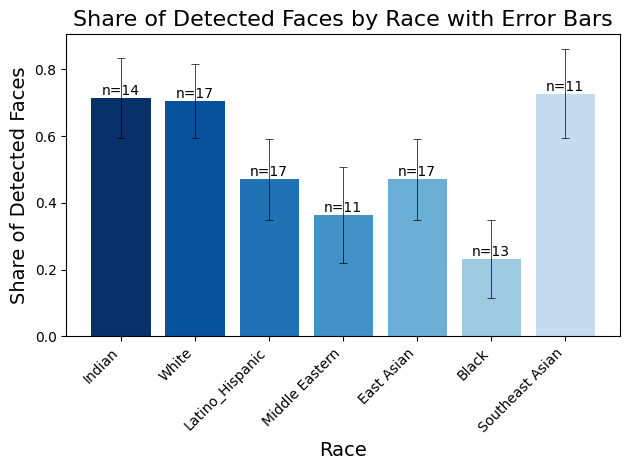

In [23]:
# Calculate the standard errors
standard_errors = {race: np.sqrt((share * (1 - share)) / total_counts[race_labels.index(race)])
                   for race, share in shares_with_labels.items()}

# Plotting again, now with error bars
fig, ax = plt.subplots()
races = list(shares_with_labels.keys())
values = list(shares_with_labels.values())
errors = list(standard_errors.values())

bars = ax.bar(
    races,
    values,
    yerr=errors,
    capsize=5,
    color=plotting_colors,
    error_kw=dict(elinewidth=0.5, ecolor='black', capsize=3, capthick=0.5)
)
ax.set_xlabel('Race', fontsize=14)
ax.set_ylabel('Share of Detected Faces', fontsize=14)
ax.set_title('Share of Detected Faces by Race with Error Bars', fontsize=16)
ax.set_xticklabels(races, rotation=45, ha="right")

# Adding the total count above each bar
for bar, race in zip(bars, races):
    yval = bar.get_height()
    total = total_counts[race_labels.index(race)]  # get the total count for the race
    ax.text(bar.get_x() + bar.get_width()/2, yval, f'n={total}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


Do you think the classifier's performance is biased? More generally, do you think this is a valid auditing exercise? Why (not)?

The Cascade classifier is a rather simple (classical) machine learning model. Do you think that bias-related concerns would increase or decrease with the transition to more sophisticated (neural) nets? Why (not)?

In the following, we will see some of the explicit feature extraction approaches discussed in the lecture.

In [24]:
# Color histogram

# Get the image from the URL
url = "https://raw.githubusercontent.com/philinew/css_images_audio/main/data/images/cat.png"
resp = requests.get(url, stream=True).raw

# Convert the data to a numpy array and read it into an OpenCV image
image_arr = np.asarray(bytearray(resp.read()), dtype="uint8")
cat_image = cv2.cvtColor(cv2.imdecode(image_arr, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)

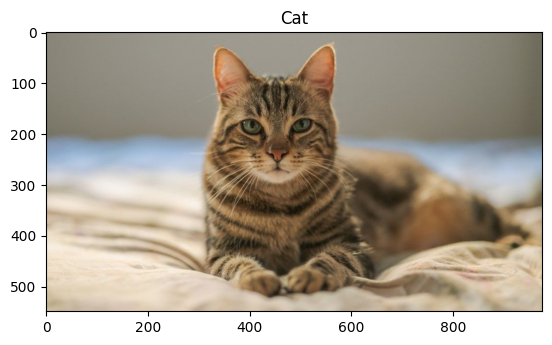

In [25]:
# Let's plot our cat
plt.imshow(cat_image)
plt.title('Cat')
plt.show()

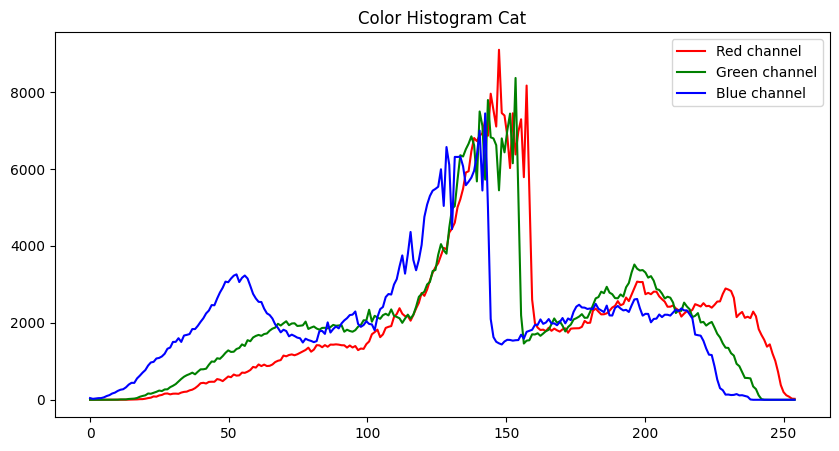

In [26]:
# Split the image into its color channels
channels_cat = cv2.split(cat_image)

# Set the colors and labels for the plot
colors_cat = ('r', 'g', 'b')
labels_cat = ("Red", "Green", "Blue")

# Plot the histogram for each color channel
plt.figure(figsize=(10, 5))
for channel_cat, color_cat, label_cat in zip(channels_cat, colors_cat, labels_cat):
    histogram_cat, bin_edges_cat = np.histogram(
        channel_cat, bins=256, range=(0, 255)
    )
    plt.plot(bin_edges_cat[0:-1], histogram_cat, color=color_cat, label=f'{label_cat} channel')

# Add title and legend to the plot and show it
plt.title('Color Histogram Cat')
plt.legend()
plt.show()
plt.close()

In [27]:
# For comparison, let's look at the histogram of another image

# Get the image from the URL
url = "https://raw.githubusercontent.com/philinew/css_images_audio/main/data/images/fish.jpg"
resp = requests.get(url, stream=True).raw

# Convert the data to a numpy array and read it into an OpenCV image
image_arr = np.asarray(bytearray(resp.read()), dtype="uint8")
fish_image = cv2.cvtColor(cv2.imdecode(image_arr, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)

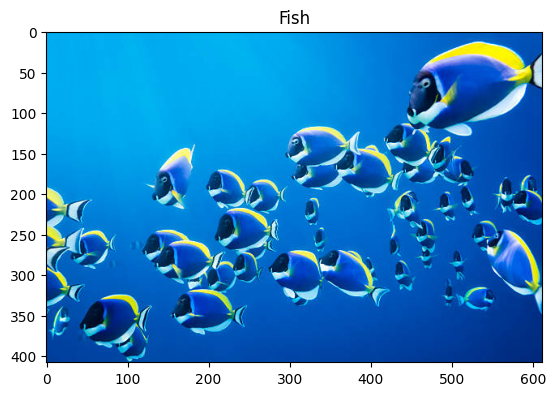

In [28]:
# Let's plot our fish
# Looking at the picture, what do you expect for the histogram?
plt.imshow(fish_image)
plt.title('Fish')
plt.show()

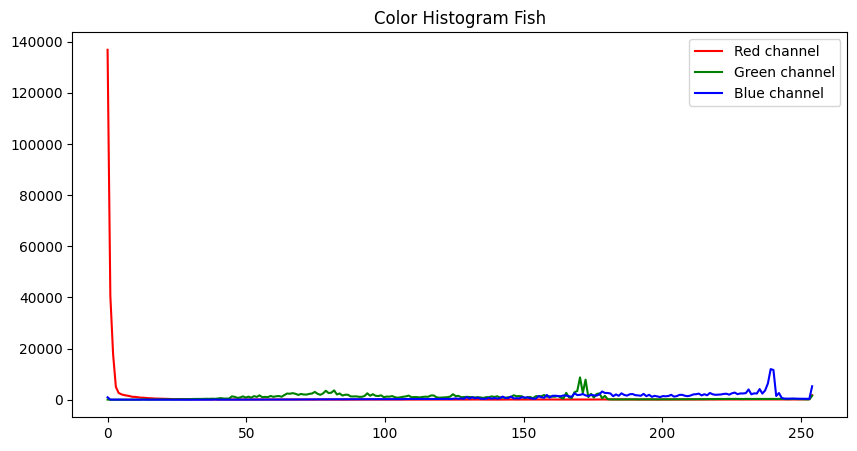

In [29]:
# Again, split the image into its color channels
channels_fish = cv2.split(fish_image)

# Set the colors and labels for the plot
colors_fish = ('r', 'g', 'b')
labels_fish = ("Red", "Green", "Blue")

# Plot the histogram for each color channel
plt.figure(figsize=(10, 5))
for channel_fish, color_fish, label_fish in zip(channels_fish, colors_fish, labels_fish):
    histogram_fish, bin_edges_fish = np.histogram(
        channel_fish, bins=256, range=(0, 255)
    )
    plt.plot(bin_edges_fish[0:-1], histogram_fish, color=color_fish, label=f'{label_fish} channel')

# Add title and legend to the plot
plt.title('Color Histogram Fish')
plt.legend()
plt.show()
plt.close()

In [30]:
# As an example for a texture feature, let us look at entropy in the fish image

# Convert the image to grayscale
fish_gray = cv2.cvtColor(fish_image, cv2.COLOR_BGR2GRAY)

# Function to compute the entropy of a region in the image
def local_entropy(region):
    hist = np.histogram(region, bins=256, range=(0, 256))[0]
    hist = hist / np.sum(hist)
    hist = hist[hist > 0]  # eliminate zeros
    return -np.sum(hist * np.log2(hist))

# Compute the local entropy for each pixel using a window size of 9x9
entropy_image = generic_filter(fish_gray, local_entropy, size=9)

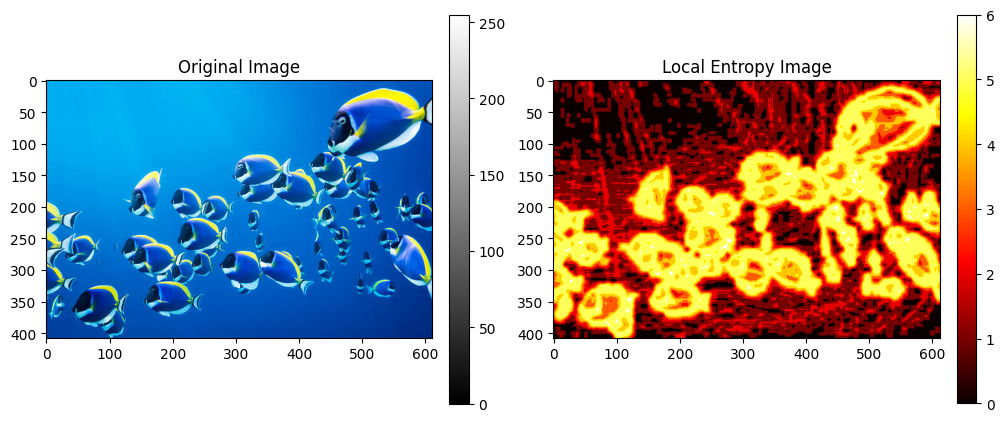

In [31]:
# Show the original image and entropy image
fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

# Original Image
ax0 = plt.subplot(gs[0])
ax0.imshow(fish_image, cmap='gray')
ax0.set_title('Original Image')
fig.colorbar(ax0.imshow(fish_image, cmap='gray'), ax=ax0, fraction=0.046, pad=0.04)

# Local Entropy Image
ax1 = plt.subplot(gs[1])
im1 = ax1.imshow(entropy_image, cmap='hot')
ax1.set_title('Local Entropy Image')
fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)

plt.show()

In [32]:
# Next, let us visualize the HOG features

<ipython-input-33-7ebfb38f1249>:8: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  features, hog_image = hog(fish_gray, orientations=8, pixels_per_cell=(16, 16),


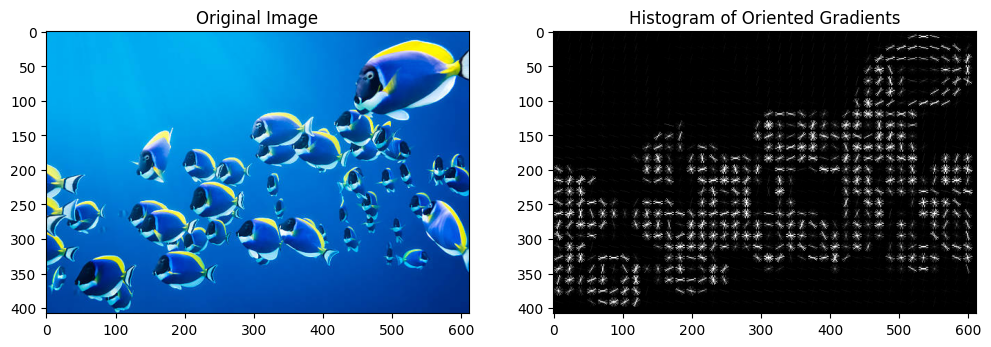

In [33]:
# Compute HOG features

from skimage.feature import hog
from skimage import exposure



features, hog_image = hog(fish_gray, orientations=8, pixels_per_cell=(16, 16),
                          cells_per_block=(1, 1), visualize=True, multichannel=False)

# Improve the visualization
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

# Plot the results
plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(fish_image, cmap=plt.cm.gray)
plt.title('Original Image')

# HOG Image
plt.subplot(1, 2, 2)
plt.imshow(hog_image_rescaled, cmap=plt.cm.gray)
plt.title('Histogram of Oriented Gradients')

plt.show()

In [34]:
# For a better intuition of HOG's working, you may want to check out the shape of the features object (optional)
print(features.shape)

# Why this shape?
image_shape = fish_gray.shape
cell_shape = (16, 16)
block_shape = (1, 1)
orientations = 8

total_cells_x = image_shape[1] // cell_shape[1]
total_cells_y = image_shape[0] // cell_shape[0]

length_features = total_cells_y * total_cells_x * orientations * block_shape[0] * block_shape[1]

print(length_features)

(7600,)
7600


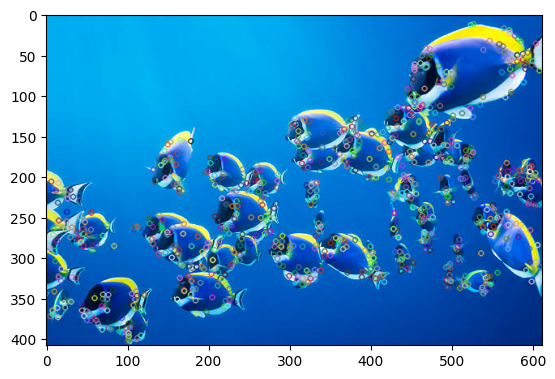

In [35]:
# Create a SIFT object
sift = cv2.SIFT_create()

# Detect keypoints in the image
keypoints = sift.detect(fish_image, None)

# Draw keypoints on the image
img_keypoints = cv2.drawKeypoints(fish_image, keypoints, outImage=None)

# Display the image with keypoints
plt.imshow(img_keypoints)
plt.show()